# Оцениваем регрессии на данных HS0 в спецификациях:
- Фиксированные эффекты ~ ковид и ограничения
- Фиксированные эффекты ~ ковид и ограничения | инструментальные переменные
- В перспективе: суммарный экспорт/импорт в зависимости от ковида (+ IV)

In [1]:
library(arrow)
library(stargazer)
library(tidyverse)
library(plotly)
library(fixest)


Присоединяю пакет: 'arrow'


Следующий объект скрыт от 'package:utils':

    timestamp



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


Warning message:
"пакет 'tidyverse' был собран под R версии 4.4.2"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"пакет 'plotly' был собран под R версии 4.4.2"

Присоеди

## Фиксированные эффекты

### Экспорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [31]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_export_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,4.858130,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,-6.219868,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,5.237020,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,2.576115,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,7.712751,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,-4.746044,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


### Рисую обычный и demeaned scatterplot, чтобы обосновать необходимость использования фиксированных эффектов

Графики будут интерактивные, если раскомментить ggplotly, закомментить p и перепрогнать

Warning message:
"Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`)."


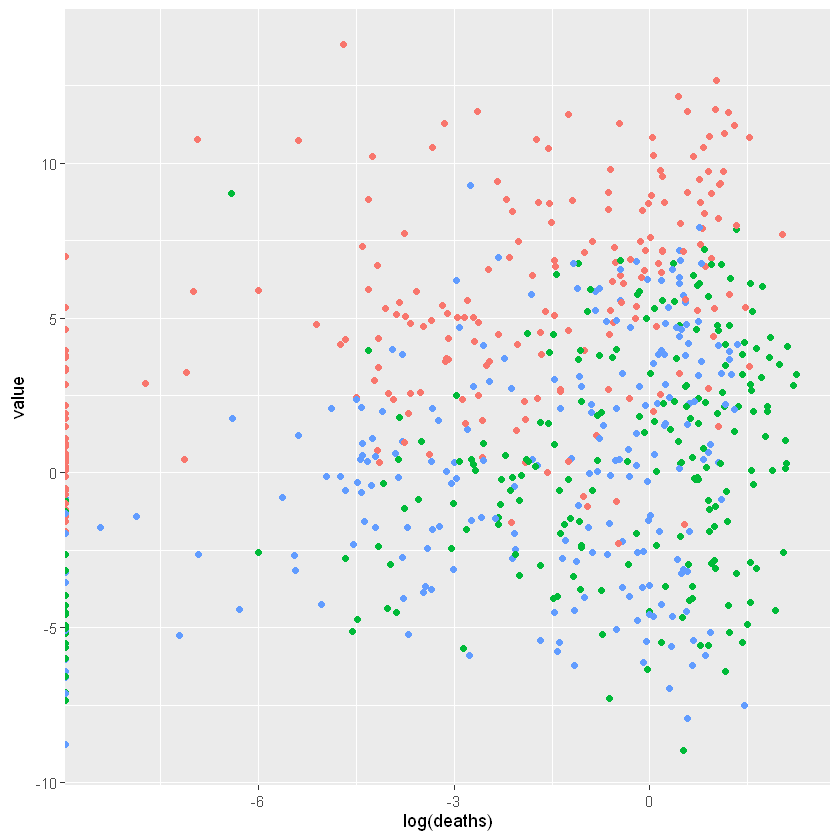

In [32]:
p = ggplot(df, aes(x = log(deaths), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p) 
p   

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


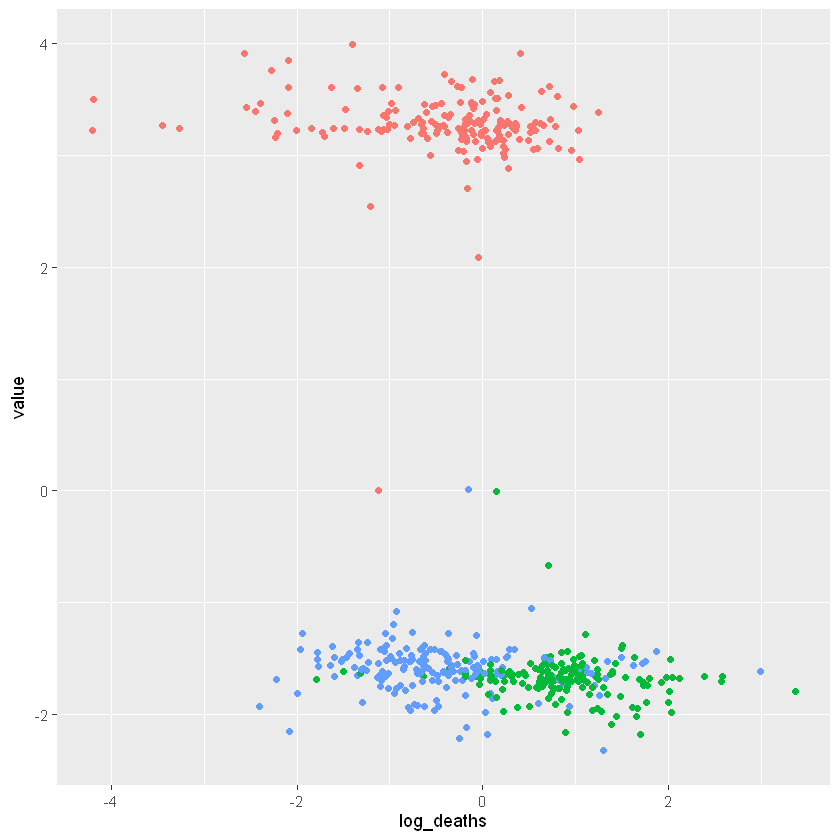

In [33]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log(deaths), na.rm = TRUE))  %>% filter(avg_log_deaths > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_deaths = log(deaths)- avg_log_deaths, value = value- avg_value) %>%
   select(country, year, log_deaths, value)
p = ggplot(demeaned_df, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


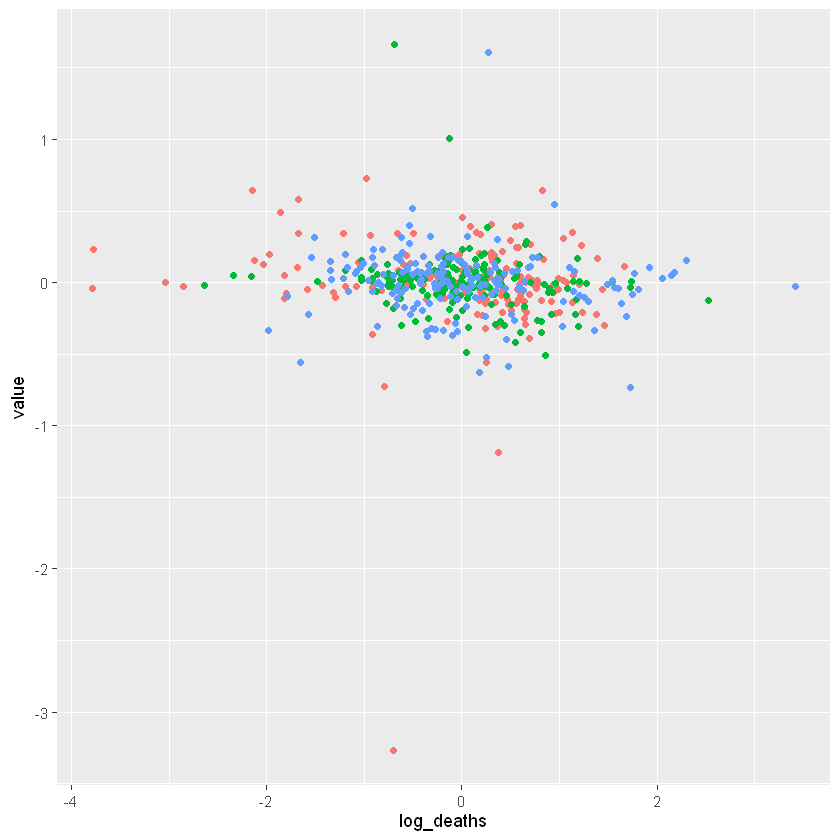

In [34]:
year_means_df = demeaned_df %>% filter(log_deaths > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log_deaths, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_deaths = log_deaths- avg_log_deaths, value = value - avg_value) %>%
   select(country, year, log_deaths, value)

p = ggplot(demeaned_df2, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

In [35]:
year_means_df

year,avg_value,avg_log_deaths
<chr>,<dbl>,<dbl>
2020,3.269161,-0.4166008
2021,-1.674689,0.8422965
2022,-1.594472,-0.4280231


Warning message:
"Removed 128 rows containing missing values or values outside the scale range
(`geom_point()`)."


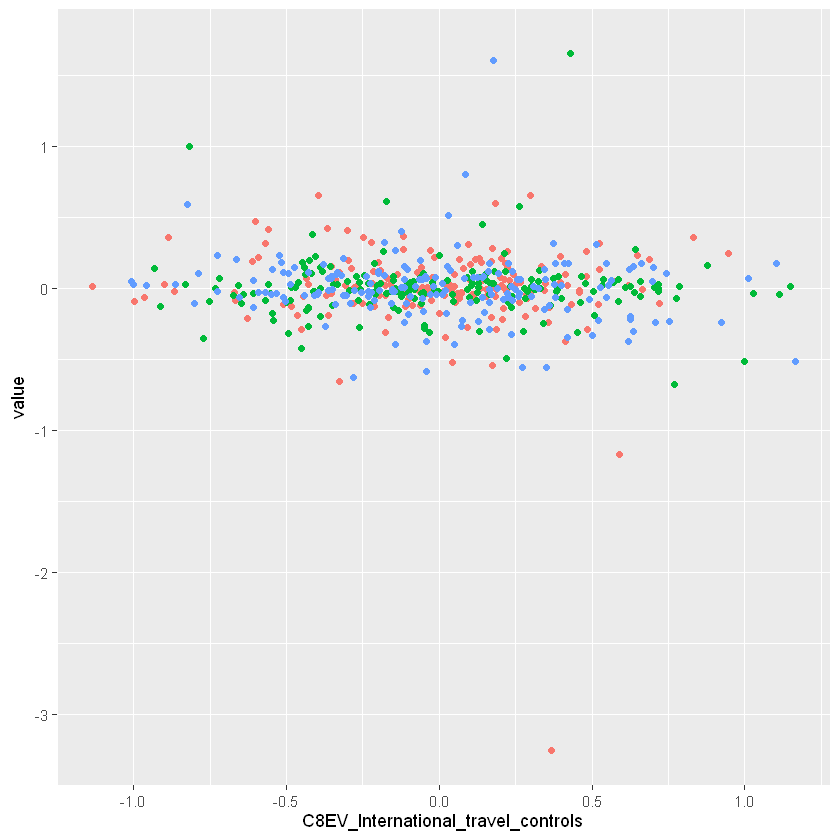

In [36]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_C8EV_International_travel_controls = mean(C8EV_International_travel_controls, na.rm = TRUE))

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(C8EV_International_travel_controls = C8EV_International_travel_controls- avg_C8EV_International_travel_controls, value = value- avg_value) %>%
   select(country, year, C8EV_International_travel_controls, value)
   
year_means_df = demeaned_df %>% filter(C8EV_International_travel_controls > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_C8EV_International_travel_controls = mean(C8EV_International_travel_controls, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(C8EV_International_travel_controls = C8EV_International_travel_controls- avg_C8EV_International_travel_controls, value = value - avg_value) %>%
   select(country, year, C8EV_International_travel_controls, value)

p = ggplot(demeaned_df2, aes(x = C8EV_International_travel_controls, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

### Сами регрессии

In [37]:
# Pulled OLS
export_pulled_ols = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| year,
 data = df)
export_pulled_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                                   Estimate Std. Error t value   Pr(>|t|)    
log(deaths)                        0.563746   0.099325 5.67577 5.6726e-08 ***
C8EV_International_travel_controls 0.701125   0.321204 2.18281 3.0390e-02 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 2.97233     Adj. R2: 0.444767
                Within R2: 0.140638

In [41]:
export_fe_ols = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country + year,
 data = df)
export_fe_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error  t value  Pr(>|t|)    
log(deaths)                        -0.036593   0.013369 -2.73708 0.0068426 ** 
C8EV_International_travel_controls -0.049067   0.029783 -1.64748 0.1012633    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.173731     Adj. R2: 0.997084
                 Within R2: 0.034409

In [51]:
# Тут всё экзогенно
export_covid_iv = feols(value ~ 1 + C8EV_International_travel_controls|country + year|
 log(deaths) ~ 
#  H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
export_covid_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, RHS: 126, IV: 74/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)                    -0.014171   0.039132 -0.362131  0.71769 
C8EV_International_travel_controls -0.039104   0.030609 -1.277500  0.20313 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.175014     Adj. R2: 0.997035
                 Within R2: 0.023475
F-test (1st stage), log(deaths): stat = 14.2     , p = 6.809e-9, on 3 and 494 DoF.
                     Wu-Hausman: stat =  0.314932, p = 0.575061, on 1 and 321 DoF.
                         Sargan: stat =  2.91965 , p = 0.232277, on 2 DoF.

In [49]:
export_all_iv = feols(value ~ 1 |country + year|
 log(deaths) + C8EV_International_travel_controls ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
export_all_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, IV: 154/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths), C8EV_International_travel_controls
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                        Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)                         0.040970   0.054258  0.755083  0.45122 
fit_C8EV_International_travel_controls -0.154842   0.112054 -1.381846  0.16879 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.193669     Adj. R2:  0.996369
                 Within R2: -0.195801
F-test (1st stage), log(deaths)                       : stat =  8.63355 , p = 1.355e-5, on 3 and 495 DoF.
F-test (1st stage), C8EV_International_travel_controls: stat = 12.9     , p = 4.052e-8, on 3 and 495 DoF.
                                            Wu-Hausman: stat =  0.560417, p = 0.57153 , 

In [44]:
# Гетерогенность во времени
export_time_effects = feols(value ~ year/log(deaths) + year/C8EV_International_travel_controls| country,
 data = df)
export_time_effects %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                             Estimate Std. Error    t value
year2021                                    -4.994896   0.105374 -47.401774
year2022                                    -5.027781   0.110254 -45.601905
year2020:log(deaths)                        -0.047159   0.016111  -2.927121
year2021:log(deaths)                        -0.036435   0.015113  -2.410815
year2022:log(deaths)                        -0.029721   0.014896  -1.995227
year2020:C8EV_International_travel_controls -0.076754   0.046456  -1.652197
year2021:C8EV_International_travel_controls -0.041017   0.033867  -1.211131
year2022:C8EV_International_travel_controls -0.014681   0.047672  -0.307962
                                             Pr(>|t|)    
year2021                                    < 2.2e-16 ***
year2022                                    < 2.2e-16 ***
year2020:log(deaths)     

In [45]:
# Гетерогенность во времени
export_covid_time_effects = feols(value ~ year/log(deaths)| country,
 data = df)
export_covid_time_effects %>% summary(vcov = ~country)
# Ядро крашится почему-то
# feols(value ~ 1| country|
# year/log(deaths)~C1M_School_closing+median_age+population_density,
#  data = df) %>% summary(vcov = ~country)

NOTE: 76 observations removed because of NA and infinite values (LHS: 2, RHS: 74).



OLS estimation, Dep. Var.: value
Observations: 583
Fixed-effects: country: 210
Standard-errors: Clustered (country) 
                      Estimate Std. Error    t value   Pr(>|t|)    
year2021             -4.898938   0.031134 -157.35089  < 2.2e-16 ***
year2022             -4.868733   0.033772 -144.16483  < 2.2e-16 ***
year2020:log(deaths) -0.052960   0.015411   -3.43655 0.00071073 ***
year2021:log(deaths) -0.045316   0.015409   -2.94095 0.00364076 ** 
year2022:log(deaths) -0.033211   0.014880   -2.23194 0.02668008 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.189434     Adj. R2: 0.996996
                 Within R2: 0.992858

In [70]:
etable(export_fe_ols, export_time_effects, export_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf)

,,export_fe_ols,export_time_effe..,export_covid_iv
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value
2,,,,
3,log(deaths),-0.0366** (0.0134),,-0.0142 (0.0391)
4,C8EV_International_travel_controls,-0.0491 (0.0298),,-0.0391 (0.0306)
5,year2021,,-4.995*** (0.1054),
6,year2022,,-5.028*** (0.1103),
7,year2020 x log(deaths),,-0.0472** (0.0161),
8,year2021 x log(deaths),,-0.0364* (0.0151),
9,year2022 x log(deaths),,-0.0297* (0.0149),


In [71]:
etable(export_fe_ols, export_time_effects, export_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf, tex=TRUE)

\begingroup
\centering
\begin{tabular}{lccc}
   \tabularnewline \midrule \midrule
   Dependent Variable: & \multicolumn{3}{c}{value}\\
   Model:                                                      & (1)             & (2)             & (3)\\  
   \midrule
   \emph{Variables}\\
   log(deaths)                                                 & -0.0366$^{***}$ &                 & -0.0142\\   
                                                               & (0.0134)        &                 & (0.0391)\\   
   C8EV\_International\_travel\_controls                       & -0.0491         &                 & -0.0391\\   
                                                               & (0.0298)        &                 & (0.0306)\\   
   year2021                                                    &                 & -4.995$^{***}$  &   \\   
                                                               &                 & (0.1054)        &   \\   
   year2022                                   

In [ ]:
# Попытка реплицировать (Berthou, 2024)
m = feols(value ~ StringencyIndex_Average + log(deaths)| country + year,
 data = df)
m %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error  t value Pr(>|t|)    
StringencyIndex_Average -0.001757   0.001390 -1.26337 0.208147    
log(deaths)             -0.029375   0.012601 -2.33122 0.020888 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.174355     Adj. R2: 0.997063
                 Within R2: 0.027457

### Импорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [53]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_import_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C1M_School_closing,C2M_Workplace_closing,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2020,SLV,2.321174,SLV,2020,19.6259116,0.57060773,NA,2.426229,1.4344262,⋯,11.0,24.14867,17.73575,SLV,3.92,8.46,36.01,37.84,2020,0
2022,ASM,-2.471433,ASM,2022,467.6200274,1.92600000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2022,0
2020,BOL,1.776656,BOL,2020,35.1308840,2.07754144,NA,2.418033,1.8306011,⋯,21.0,22.42107,41.25143,BOL,3.53,20.34,34.82,27.64,2020,0
2020,SLE,1.100952,SLE,2020,0.8507182,0.02530387,NA,1.606557,0.2349727,⋯,80.3,35.38844,15.18978,SLE,5.29,6.42,20.52,33.28,2020,0
2020,LKA,3.031731,LKA,2020,4.9664917,0.02309392,NA,1.931694,0.5546448,⋯,6.0,14.93368,NA,NA,NA,NA,NA,NA,2020,0
2022,ATG,-1.252042,ATG,2022,143.9042740,0.82619178,NA,NA,NA,⋯,8.1,NA,NA,NA,NA,NA,NA,NA,2022,0


### Рисую обычный и demeaned scatterplot, чтобы обосновать необходимость использования фиксированных эффектов

Графики будут интерактивные, если раскомментить ggplotly, закомментить p и перепрогнать

Warning message:
"Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`)."


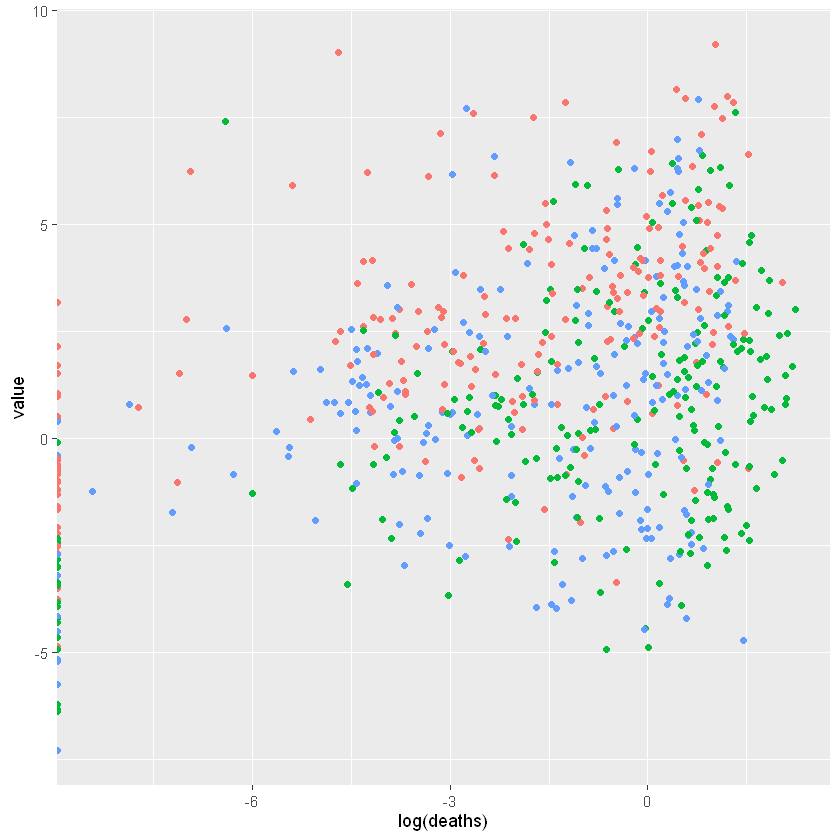

In [54]:
p = ggplot(df, aes(x = log(deaths), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p) 
p   

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


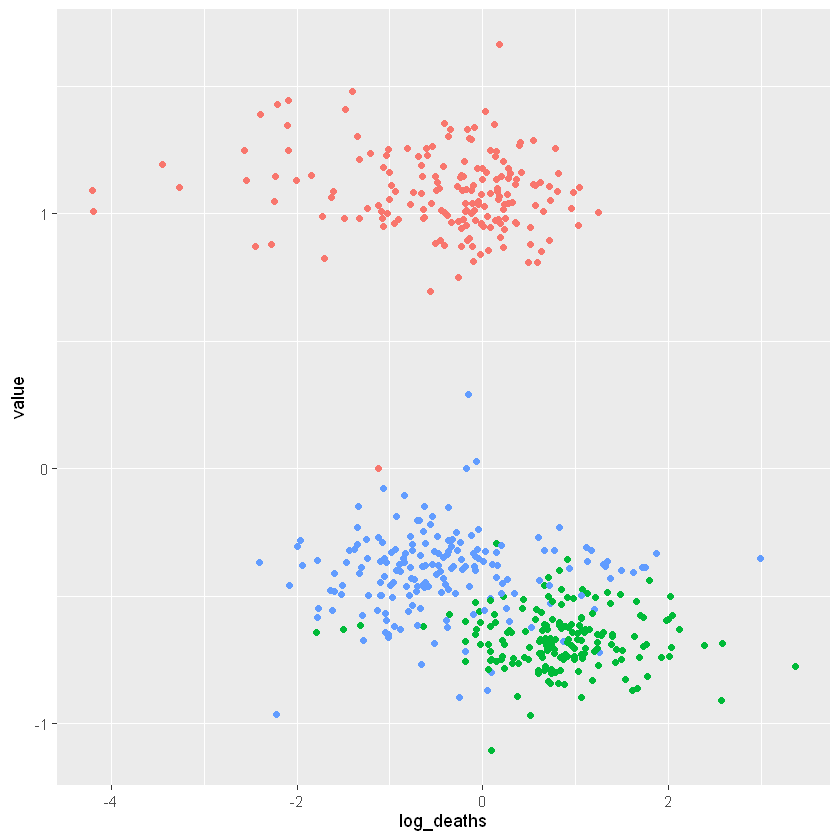

In [55]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log(deaths), na.rm = TRUE))  %>% filter(avg_log_deaths > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_deaths = log(deaths)- avg_log_deaths, value = value- avg_value) %>%
   select(country, year, log_deaths, value)
p = ggplot(demeaned_df, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


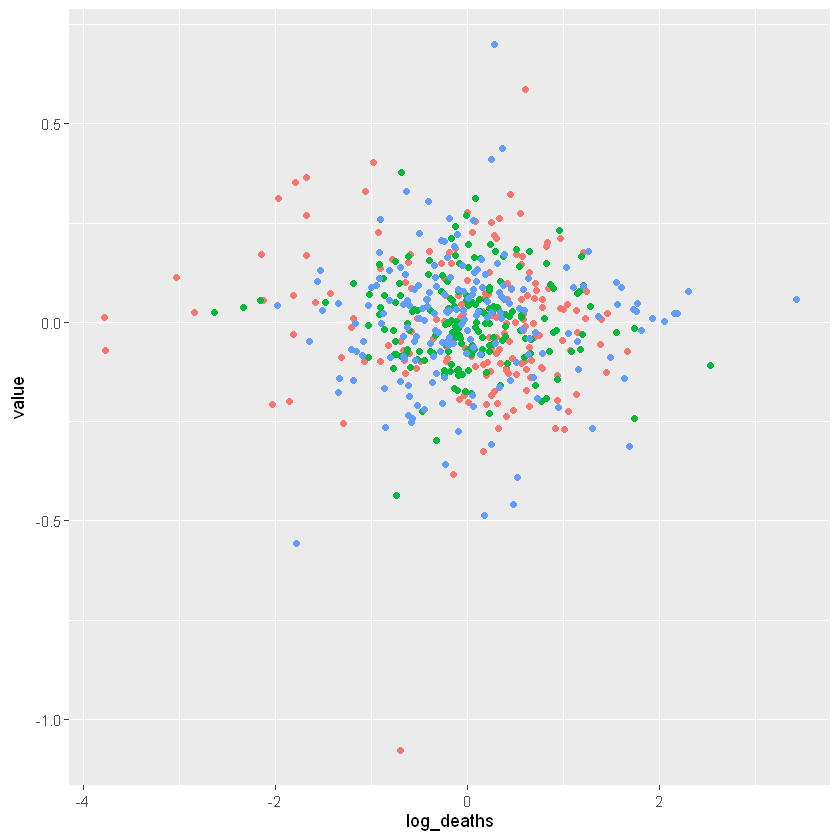

In [56]:
year_means_df = demeaned_df %>% filter(log_deaths > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log_deaths, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_deaths = log_deaths- avg_log_deaths, value = value - avg_value) %>%
   select(country, year, log_deaths, value)

p = ggplot(demeaned_df2, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

In [57]:
year_means_df

year,avg_value,avg_log_deaths
<chr>,<dbl>,<dbl>
2020,1.0785846,-0.4166008
2021,-0.6694262,0.8422965
2022,-0.4091583,-0.4280231


Warning message:
"Removed 128 rows containing missing values or values outside the scale range
(`geom_point()`)."


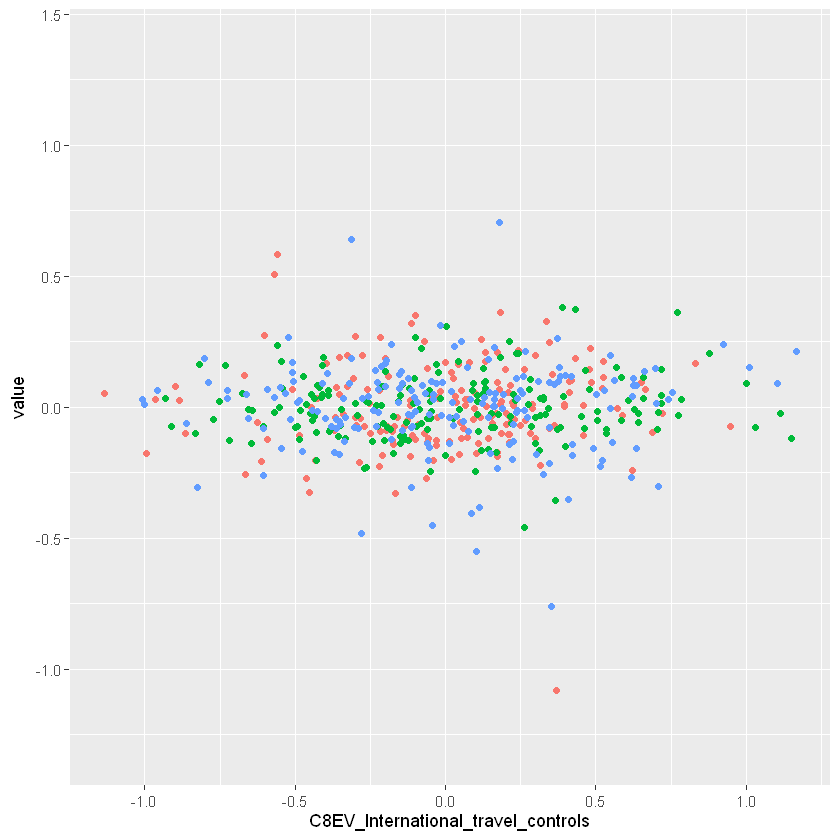

In [58]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_C8EV_International_travel_controls = mean(C8EV_International_travel_controls, na.rm = TRUE))

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(C8EV_International_travel_controls = C8EV_International_travel_controls- avg_C8EV_International_travel_controls, value = value- avg_value) %>%
   select(country, year, C8EV_International_travel_controls, value)
   
year_means_df = demeaned_df %>% filter(C8EV_International_travel_controls > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_C8EV_International_travel_controls = mean(C8EV_International_travel_controls, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(C8EV_International_travel_controls = C8EV_International_travel_controls- avg_C8EV_International_travel_controls, value = value - avg_value) %>%
   select(country, year, C8EV_International_travel_controls, value)

p = ggplot(demeaned_df2, aes(x = C8EV_International_travel_controls, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

### Сами регрессии

In [59]:
# Pulled OLS
import_pulled_ols = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| year,
 data = df)
import_pulled_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: year: 3
Standard-errors: Clustered (country) 
                                   Estimate Std. Error t value   Pr(>|t|)    
log(deaths)                        0.339659   0.070520 4.81652 3.1622e-06 ***
C8EV_International_travel_controls 0.489371   0.226937 2.15641 3.2424e-02 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 2.1876     Adj. R2: 0.205771
               Within R2: 0.101741

In [60]:
import_fe_ols = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country + year,
 data = df)
import_fe_ols %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|) 
log(deaths)                        -0.000596   0.010604 -0.056233  0.95522 
C8EV_International_travel_controls -0.004258   0.016856 -0.252587  0.80089 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.135456     Adj. R2: 0.99532 
                 Within R2: 1.485e-4

In [61]:
# Тут всё экзогенно
import_covid_iv = feols(value ~ 1 + C8EV_International_travel_controls|country + year|
 log(deaths) ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
import_covid_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, RHS: 126, IV: 74/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                    Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)                    -0.000599   0.030936 -0.019365  0.98457 
C8EV_International_travel_controls -0.004370   0.021298 -0.205170  0.83768 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.135203     Adj. R2: 0.995333
                 Within R2: 1.498e-4
F-test (1st stage), log(deaths): stat = 14.2     , p = 6.809e-9, on 3 and 494 DoF.
                     Wu-Hausman: stat =  1.268e-5, p = 0.997161, on 1 and 321 DoF.
                         Sargan: stat =  0.158475, p = 0.923821, on 2 DoF.

In [62]:
import_all_iv = feols(value ~ 1 |country + year|
 log(deaths) + C8EV_International_travel_controls ~ #H6M_Facial_Coverings+
 C1M_School_closing+median_age+population_density,
 data = df)
import_all_iv %>% summary(vcov = ~country)

NOTE: 158 observations removed because of NA and infinite values (LHS: 2, IV: 154/130).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths), C8EV_International_travel_controls
                  Instr.   : C1M_School_closing, median_age, population_density
Second stage: Dep. Var.: value
Observations: 501
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                                        Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)                        -0.013834   0.033116 -0.417735  0.67666 
fit_C8EV_International_travel_controls  0.023410   0.079176  0.295666  0.76784 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.13631     Adj. R2:  0.995256
                Within R2: -0.016291
F-test (1st stage), log(deaths)                       : stat =  8.63355 , p = 1.355e-5, on 3 and 495 DoF.
F-test (1st stage), C8EV_International_travel_controls: stat = 12.9     , p = 4.052e-8, on 3 and 495 DoF.
                                            Wu-Hausman: stat =  0.03835 , p = 0.96238 , on

In [63]:
# Гетерогенность во времени
import_time_effects = feols(value ~ year/log(deaths) + year/C8EV_International_travel_controls| country,
 data = df)
import_time_effects %>% summary(vcov = ~country)

feols(value ~ year/log(deaths) + C8EV_International_travel_controls| country,
 data = df) %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                             Estimate Std. Error    t value
year2021                                    -1.697528   0.086705 -19.578137
year2022                                    -1.397096   0.098158 -14.233097
year2020:log(deaths)                        -0.015986   0.012438  -1.285298
year2021:log(deaths)                         0.001662   0.013993   0.118772
year2022:log(deaths)                         0.016284   0.011734   1.387787
year2020:C8EV_International_travel_controls  0.023331   0.036680   0.636083
year2021:C8EV_International_travel_controls  0.007195   0.017225   0.417706
year2022:C8EV_International_travel_controls  0.005205   0.047428   0.109748
                                             Pr(>|t|)    
year2021                                    < 2.2e-16 ***
year2022                                    < 2.2e-16 ***
year2020:log(deaths)     

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175
Standard-errors: Clustered (country) 
                                    Estimate Std. Error    t value  Pr(>|t|)
year2021                           -1.735736   0.022717 -76.408213 < 2.2e-16
year2022                           -1.433614   0.041711 -34.370504 < 2.2e-16
C8EV_International_travel_controls  0.009941   0.018635   0.533483   0.59438
year2020:log(deaths)               -0.016772   0.011634  -1.441574   0.15122
year2021:log(deaths)                0.000696   0.013027   0.053442   0.95744
year2022:log(deaths)                0.015835   0.011622   1.362514   0.17480
                                      
year2021                           ***
year2022                           ***
C8EV_International_travel_controls    
year2020:log(deaths)                  
year2021:log(deaths)                  
year2022:log(deaths)                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE

In [64]:
# Гетерогенность во времени
import_covid_time_effects = feols(value ~ year/log(deaths)| country,
 data = df)
import_covid_time_effects %>% summary(vcov = ~country)
# Ядро крашится почему-то
# feols(value ~ 1| country|
# year/log(deaths)~C1M_School_closing+median_age+population_density,
#  data = df) %>% summary(vcov = ~country)

NOTE: 76 observations removed because of NA and infinite values (LHS: 2, RHS: 74).



OLS estimation, Dep. Var.: value
Observations: 583
Fixed-effects: country: 210
Standard-errors: Clustered (country) 
                      Estimate Std. Error    t value  Pr(>|t|)    
year2021             -1.736273   0.021463 -80.896340 < 2.2e-16 ***
year2022             -1.435496   0.020997 -68.368321 < 2.2e-16 ***
year2020:log(deaths) -0.020469   0.011199  -1.827768   0.06901 .  
year2021:log(deaths) -0.000043   0.012479  -0.003408   0.99728    
year2022:log(deaths)  0.014333   0.010783   1.329270   0.18521    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.138164     Adj. R2: 0.995859
                 Within R2: 0.966848

In [73]:
etable(import_fe_ols, import_time_effects, import_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf, tex=FALSE)

,,import_fe_ols,import_time_effe..,import_covid_iv
,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value
2,,,,
3,log(deaths),-0.0006 (0.0106),,-0.0006 (0.0309)
4,C8EV_International_travel_controls,-0.0043 (0.0169),,-0.0044 (0.0213)
5,year2021,,-1.698*** (0.0867),
6,year2022,,-1.397*** (0.0982),
7,year2020 x log(deaths),,-0.0160 (0.0124),
8,year2021 x log(deaths),,0.0017 (0.0140),
9,year2022 x log(deaths),,0.0163 (0.0117),


In [72]:
etable(import_fe_ols, import_time_effects, import_covid_iv, vcov = ~country, fitstat=~ . + sargan.p + wh.p + ivf, tex=TRUE)

\begingroup
\centering
\begin{tabular}{lccc}
   \tabularnewline \midrule \midrule
   Dependent Variable: & \multicolumn{3}{c}{value}\\
   Model:                                                      & (1)      & (2)            & (3)\\  
   \midrule
   \emph{Variables}\\
   log(deaths)                                                 & -0.0006  &                & -0.0006\\   
                                                               & (0.0106) &                & (0.0309)\\   
   C8EV\_International\_travel\_controls                       & -0.0043  &                & -0.0044\\   
                                                               & (0.0169) &                & (0.0213)\\   
   year2021                                                    &          & -1.698$^{***}$ &   \\   
                                                               &          & (0.0867)       &   \\   
   year2022                                                    &          & -1.397$^{***}$ &   \\   
 

In [ ]:
m = feols(value ~ StringencyIndex_Average + log(deaths)| country + year,
 data = df)
m %>% summary(vcov = ~country)

NOTE: 156 observations removed because of NA and infinite values (LHS: 2, RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 503
Fixed-effects: country: 175,  year: 3
Standard-errors: Clustered (country) 
                         Estimate Std. Error   t value Pr(>|t|) 
StringencyIndex_Average -0.001685   0.001141 -1.476210  0.14169 
log(deaths)              0.001954   0.010623  0.183984  0.85424 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.134983     Adj. R2: 0.995352
                 Within R2: 0.00712 